## Sentinel-1 Validation

***About this script:*** This code is used to validate the Sentinel-1 derived flooding estimates through a comparison against data collected from key informants through interviews conducted by the Centre for Disaster Protection. We compare flooding estimates from 20 unions in Bangladesh, across 4 different districts: Kurigram, Gaibandha, Sirajganj and Sherpur.

***Related scripts:*** The Google Earth Engine code used to generate the Sentinel-1 estimates can be found [here](https://code.earthengine.google.com/?accept_repo=users/hker/BDG_Floods_Copy)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np
pd.options.mode.chained_assignment = None  # remove default warning message on chained variable assignments

1. Read in the data

In [95]:
# Read in the interview data
df = pd.read_excel('Sentinel-1-BGD-Flooding_Flood extent_DATA.xlsx', sheet_name='Sheet1_COPY')

2. Explore/clean/validate the data

In [96]:
# CHECK: How many NA's are in each row?
# print('Number of NAs in each row')
# print(len(df) - df.count())

# Remove entries without any interview data (no values in any of the interview columns)
df = df.dropna(subset=['Interview_1', 'Interview_2', 'Interview_3'], thresh=1)

# CHECK: How many unique unions are there in the remaining data?
# Should be 20 
print('Number of unique unions that have interview data')
print(df['ADM4_EN'].nunique())

# Get list of the unique unions that were sampled
sampled_union = df['ADM4_EN'].unique().tolist()

# Normalize the fraction units and convert dates to proper type
df['flood_fraction'] = df['flood_fraction']*100
df['date']= pd.to_datetime(df['date']) 

Number of unique unions that have interview data
20


3. For a given union, extract the estimated flood start and peak dates

In [7]:
def get_start_peak_end(sel_union, date_type):
    """Return list of the estimated flood start, end, or peak dates"""
    
    col_name = "flood_{}_date".format(date_type)
    
    # Get only the data for the selected union
    df_selected = df.loc[df['ADM4_EN'] == sel_union]
    
    # Get the potential start date columns
    cols = df_selected.columns[df_selected.columns.str.contains(col_name)]
    
    # Get all of the start/peak dates within the columns
    # ASSUMPTION that the appropriate date will be in the first row 
    dates = [ pd.to_datetime(df_selected[col].iloc[0]) for col in cols if not pd.isna(pd.to_datetime(df_selected[col].iloc[0]))]
    
    return(dates)

4. Visualize the time series of Sentinel-1 estimates against the interview estimates. Include lines to indicate the estimated start, peak, and end dates.

In [106]:
def compare_estimates(sel_union): 
    """Return a graph for the selected union, comparing Sentinel-1 estimates with interview estimates"""
    
    # Get only the data for the selected union
    df_selected = df.loc[df['ADM4_EN'] == sel_union]

    # Select the relevant flooding estimate data 
    # Get the various estimates of flood extent by date (in %)
    flood_extent = df_selected[['flood_fraction', 'Interview_1','Interview_2', 'Interview_3', 'date']]
    
    # Remove columns with NA values 
    flood_extent = flood_extent.dropna(axis='columns')

    # Melt data to long format for visualization
    flood_extent_long = flood_extent.melt(id_vars=['date'])

    # Colours for the line graph 
    col_mapping = {
        'Interview_1': '#520057',
        'Interview_2': '#db00e8',
        'Interview_3': '#d096d4',
        'flood_fraction': '#ff9626'
    }
    
    # Get the start, end, and peak times
    start_dates = get_start_peak_end(sel_union, 'start')
    peak_dates = get_start_peak_end(sel_union, 'pick')
    end_dates = get_start_peak_end(sel_union, 'end')

    # Create simple line plot to compare the satellite estimates and interviewed estimates
    fig = plt.figure()
    ax = plt.axes()
    sns.lineplot(x='date', y='value', hue='variable', data=flood_extent_long, palette=col_mapping)
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Percent flooding estimate')
    plt.ylim([0, 110])
    plt.title('Estimates of flooding in {}, Bangladesh'.format(sel_union))
    
    for date in start_dates:
        plt.axvline(date, ls='--', color='#0fbd09', label='Flood Start', lw=0.75)
    for date in peak_dates:
        plt.axvline(date, ls='--', color='#f20a30', label='Flood Peak', lw=0.75)
    for date in end_dates:
        plt.axvline(date, ls='--', color='#032cfc', label='Flood End', lw=0.75)

    plt.legend(loc='lower right',  bbox_to_anchor=(1.05, 1))
    L=plt.legend()
    L.get_texts()[1].set_text('Sentinel-1')
    L.get_texts()[0].set_text('Legend')

    plt.tight_layout()
    # plt.savefig("{}.png".format(sel_union))

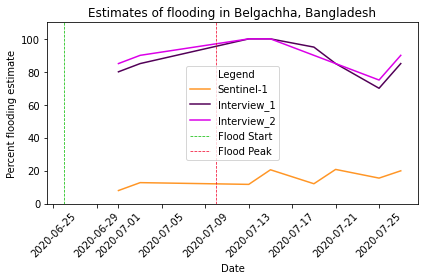

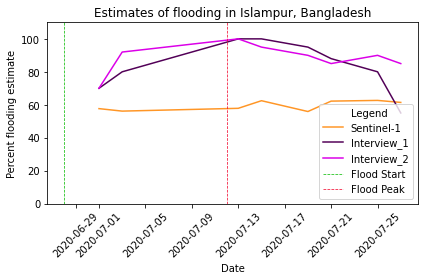

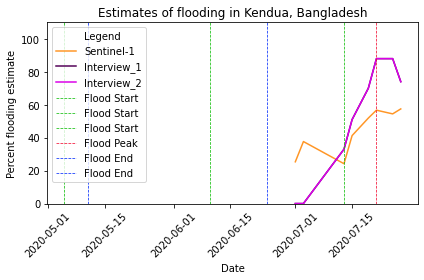

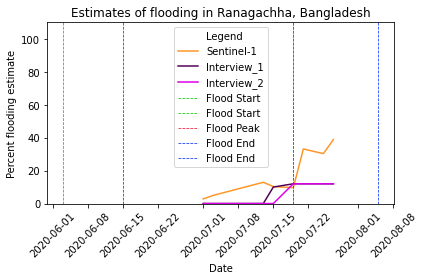

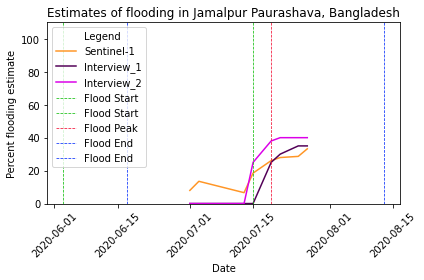

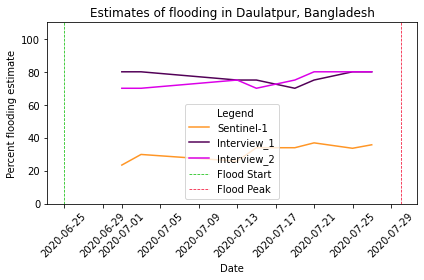

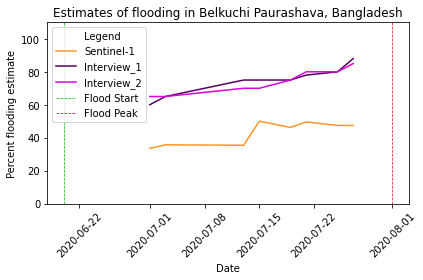

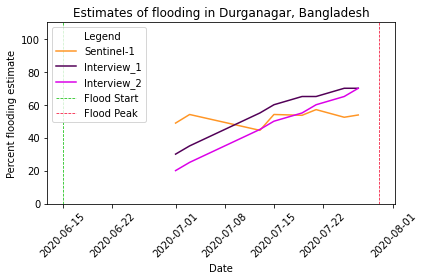

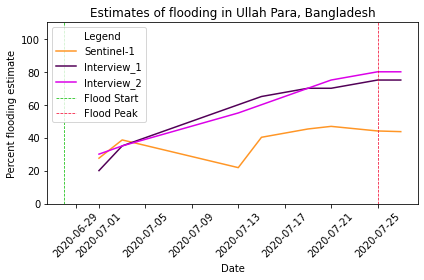

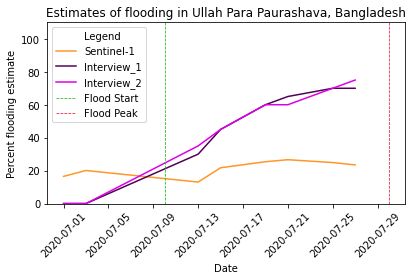

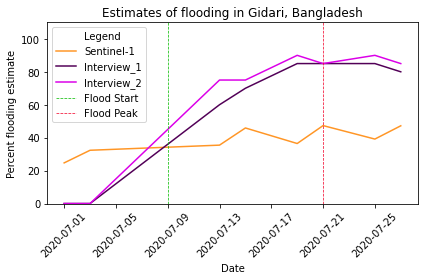

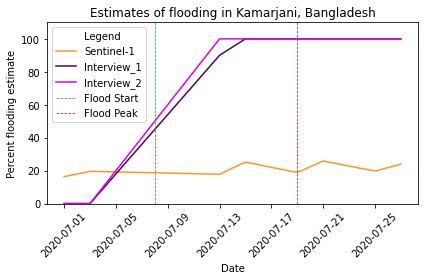

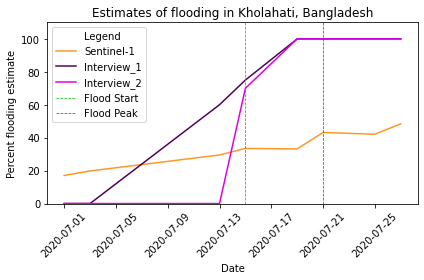

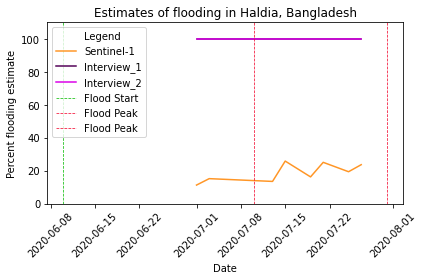

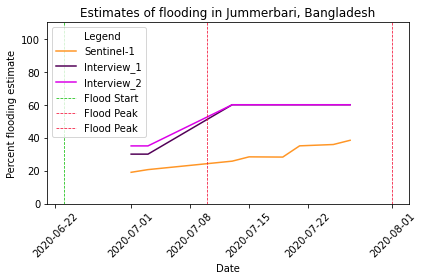

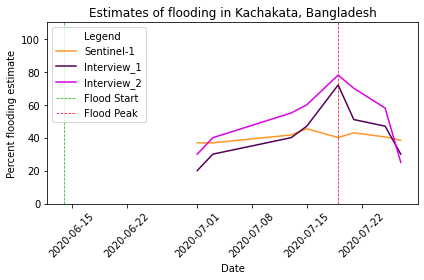

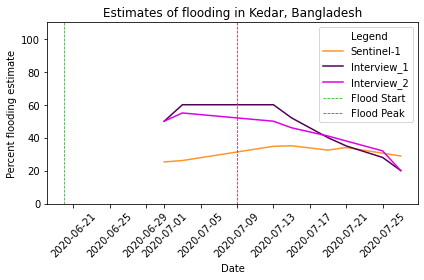

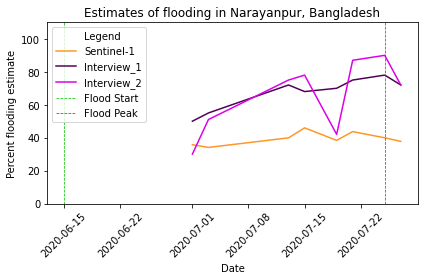

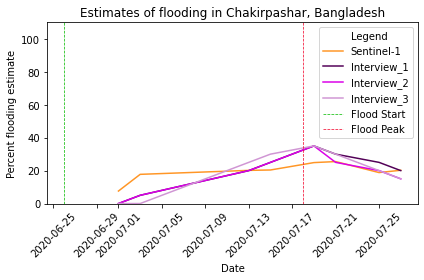

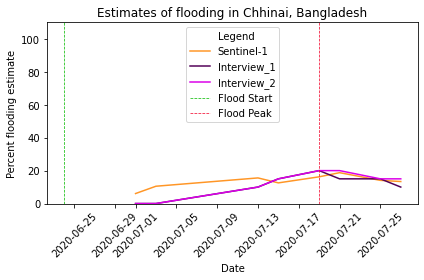

In [107]:
for union in sampled_union:
    compare_estimates(union)

5. Calculate and visualize the daily difference between the Sentinel-1 flooding estimates and the average of the interview flooding estimates. 

In [97]:
# Select columns of interest from the main dataset and create new dataframe
selected = df[['ADM4_EN', 'flood_fraction', 'Interview_1','Interview_2', 'Interview_3', 'date']]

# Get the mean flooding estimates from all the interview data
selected['Interview_Mean'] = selected[['Interview_1','Interview_2', 'Interview_3']].mean(axis=1)

# Calculate the difference from the mean interview data and the Sentinel-1 estimates
selected['Difference'] = selected['Interview_Mean'] - selected['flood_fraction'] 

# Again, select columns of interest for the heatmap
selected = selected[['ADM4_EN', 'date', 'Difference']]

# Probably not the best, but changing type to string simplifies the formatting of the dates in the plot
selected['date'] = selected.date.astype('string')

# Restructure to be suitable for heatmap format
selected_hmap = selected.pivot('ADM4_EN', 'date', 'Difference')

Text(32.99999999999999, 0.5, 'Union')

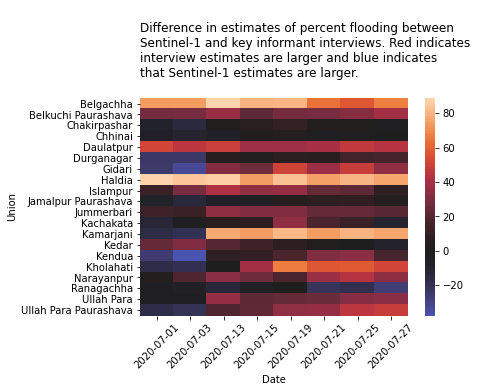

In [113]:
title = """
Difference in estimates of percent flooding between 
Sentinel-1 and key informant interviews. Red indicates 
interview estimates are larger and blue indicates 
that Sentinel-1 estimates are larger.
"""

# Create the heatmap, with diverging colour ramp centered on 0 difference
sns.heatmap(selected_hmap, center=0)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(title, loc='left')
plt.ylabel('Union')

6. Summarize the difference between Sentinel-1 and the interview data. Calculate the mean and standard deviation of daily difference between the estimates for each day.

In [116]:
# Data with standard deviation and mean daily differences
summary = []

# Loop through all of the sampled unions 
for sel_union in sampled_union: 

    # Get only the data for the selected union
    df_selected = df.loc[df['ADM4_EN'] == sel_union]

    # Get the various estimates of flood extent by date (in %)
    flood_extent = df_selected[['flood_fraction', 'Interview_1','Interview_2', 'Interview_3', 'date']]

    # Remove columns with NA values 
    flood_extent = flood_extent.dropna(axis='columns')

    # Get columns with interview data
    interview_cols = flood_extent.columns[flood_extent.columns.str.contains('Interview')]

    # Loop through each of these columns 
    for col in interview_cols:
        # Calculate avg and sd daily difference between each interview values and the Sentinel-1 values
        diff_mean = (flood_extent[col] - flood_extent['flood_fraction']).mean()
        diff_sd = (flood_extent[col] - flood_extent['flood_fraction']).std()

        # Add to the output dataframe 
        row = [sel_union, col, diff_mean, diff_sd]
        summary.append(row)

# Create the results dataframe 
summary_df = pd.DataFrame(summary, columns=['Union', 'Interview', 'Mean', 'Sdev'])

In [117]:
summary_df

,Union,Interview,Mean,Sdev
0,Belgachha,Interview_1,72.401403,11.048258
1,Belgachha,Interview_2,74.276403,9.183874
2,Islampur,Interview_1,23.981189,16.256490
3,Islampur,Interview_2,28.856189,9.308676
4,Kendua,Interview_1,6.881886,25.522056
5,Kendua,Interview_2,6.881886,25.522056
6,Ranagachha,Interview_1,-10.612818,10.728742
7,Ranagachha,Interview_2,-11.862818,9.905235
8,Jamalpur Paurashava,Interview_1,-4.679413,8.496356
9,Jamalpur Paurashava,Interview_2,2.570587,10.294946


7. Some key takeaways from this analysis: 

    * Overall, it appears that the Sentinel-1 __underestimates__ flood extent when compared against the estimates from the key informants. 
    * However, there are some cases where the Sentinel-1 estimates are greater than those from the key informants. 
    * Surprisingly, the estimates of flood start, peak, and end dates from the informants may not necessarily be aligned with their estimates of the flood extent over time (ie. the flood peak date isn't always the date with the highest flood extent).